In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D, Concatenate, Reshape,GlobalMaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
from PIL import Image
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
import math
import sys
import neptune


In [2]:
import neptune
key = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOWUxN2YwMTUtNjM1Ny00NmVlLWIzOTctNzAwYTllMGNmMTg2In0="
project = neptune.init('lassegoransson/xrayPredictor',api_token=key)

In [3]:
name = "XRAY-56"

In [4]:
!rm output/*
ex = exp = project.get_experiments(name)[0]
ex.download_artifacts()
!unzip output.zip

Archive:  output.zip
  inflating: output/model_resnet_baseline_4layerMLP_proj_checkpoint-224x224-025-0.00537.hdf5  


In [5]:
files = !find output/ -name "model*"
files

['output/model_resnet_baseline_4layerMLP_proj_checkpoint-224x224-025-0.00537.hdf5']

In [6]:
modelname = files[0]
modelpath = str(modelname.split("/")[1])
print(modelpath)
model = tf.keras.models.load_model(modelname, custom_objects={'Activation': tf.keras.layers.Activation})

model_resnet_baseline_4layerMLP_proj_checkpoint-224x224-025-0.00537.hdf5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[-0.21031581,  0.10349298,  0.22170836]],

       [[-0.12019756,  0.40804136,  0.07205181]],

       [[-0.09471446, -0.30990484, -0.30043623]]], dtype=float32)

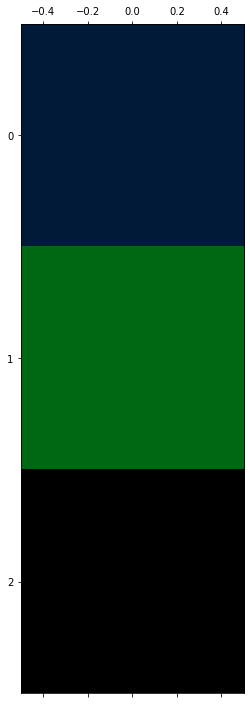

In [24]:
weights = model.layers[0].get_weights()[0][0];


plt.matshow(weights[:],cmap='viridis')
weights

In [8]:
image_height = 224
image_width = 224
test_df = pandas.read_csv("/home/lasg/bachelor-data/data_resize/allTest.csv")
test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

if model.input_shape[3] == 1:
    
    test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory='/home/lasg/bachelor-data/data_resize/',
            x_col="filename",
            y_col='label',
            target_size=(image_height, image_width),
            batch_size=1,
            shuffle=False,
            class_mode="raw",
            color_mode="grayscale"
            #color_mode="rgb"
            )
else: 
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory='/home/lasg/bachelor-data/data_resize/',
            x_col="filename",
            y_col='label',
            target_size=(image_height, image_width),
            batch_size=1,
            shuffle=False,
            class_mode="raw",
            #color_mode="grayscale"
            color_mode="rgb"
            )
        

Found 806 validated image filenames.


# Evaluate




In [9]:
n = []
nnon=[]
mse=0
hits=[0,0,0,0,0,0]
labeltrueVal = 0
labelval = 0
i=0
for b in range(0,test_generator.n):
  img,y= test_generator.next()
  img=img[0]
  sys.stdout.write("\r" + str(100*i/test_generator.n))
  label = y[0]
  predict = model.predict(np.expand_dims(img, axis=0))[0][0]
  val =(1-(label/predict))
  mse+=((1/test_generator.n)*(label-predict)*(label-predict))
  nnon.append(val)
  val=abs(val)
  n.append(val)
  if val < 0.05:
    hits[0] += 1
  if val < 0.10:
    hits[1] += 1
  if val < 0.15:
    hits[2] += 1
  if val < 0.20:
    hits[3] += 1
  if val < 0.25:
    hits[4] += 1
  if val < 0.30:
    hits[5] += 1

  #BATCH
  labeltrueVal += label
  labelval +=predict
  i+=1
  

99.8759305210918266

# Model Architecture

In [10]:
modelname.split("/")[1]

'model_resnet_baseline_4layerMLP_proj_checkpoint-224x224-025-0.00537.hdf5'

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# SCORE

In [12]:
print("")
print("MSE: "+str(mse))
print("")
print("Deviation from true weight (< 5% = 90 is project goal)")
print("< 5.0% = " +  str(100*hits[0]/(test_generator.n))+ "%")
print("< 10.0% = " + str(100*hits[1]/(test_generator.n))+ "%")
print("< 15.0% = " + str(100*hits[2]/(test_generator.n))+ "%")
print("< 20.0% = " + str(100*hits[3]/(test_generator.n))+ "%")
print("< 25.0% = " + str(100*hits[4]/(test_generator.n))+ "%")
print("< 30.0% = " + str(100*hits[5]/(test_generator.n))+ "%")
print("")
print("Deviation summed over full batch")
print("Predicted weight: "+str(labelval)+" True weight: "+str(labeltrueVal)+" Percentage: "+str((labelval/labeltrueVal)*100))


MSE: 0.005414922930980688

Deviation from true weight (< 5% = 90 is project goal)
< 5.0% = 46.526054590570716%
< 10.0% = 76.42679900744417%
< 15.0% = 92.67990074441687%
< 20.0% = 96.52605459057072%
< 25.0% = 98.38709677419355%
< 30.0% = 98.63523573200993%

Deviation summed over full batch
Predicted weight: 534.172180250287 True weight: 534.0040000000012 Percentage: 100.03149419298094


In [12]:
ex.log_metric("5%_score",100*hits[0]/(test_generator.n))

# Residuals

ValueError: zero-size array to reduction operation minimum which has no identity

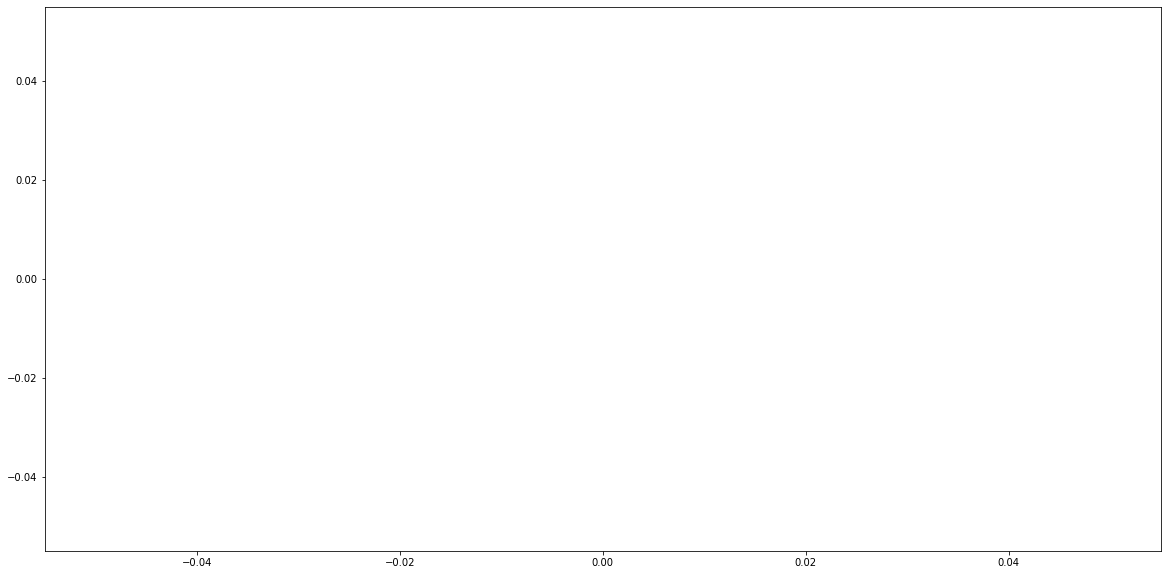

In [47]:
plt.figure(figsize=(20,10))
plt.stem(range(0,len(n)),nnon,use_line_collection=True)
plt.title('Model accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('N of test')
plt.show()

In [51]:
test_df['filename'][0]

'xrayTest/E004030006316908_2_990/1_15790006161_5E004030006316908.png'

-0.03826083485873322
xrayTest/E004030006316908_2_990/1_15790006161_5E004030006316908.png
0.8572027


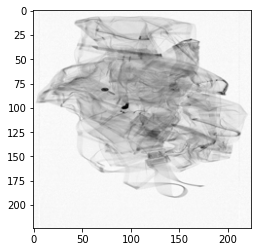

-0.06052098800447392
xrayTest/E004030006316E18_1_303/1_15731363019_4_E004030006316E18_E004030006316E18.png
0.93350345


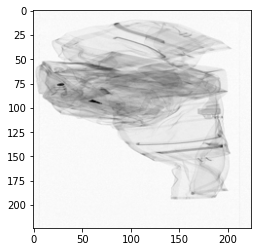

-0.1322676644953349
xrayTest/E004030006316E18_1_303/1_15731338434_4_E004030006316E18_E004030006316E18.png
0.87435156


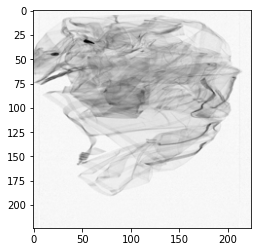

-0.08201450326407511
xrayTest/E004030006333988_3_598/0_15784168322_4E004030006333988_01001.png
0.8225398


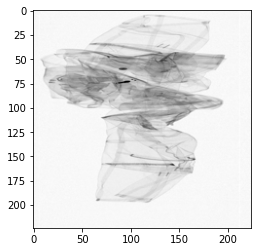

0.007389276556271085
xrayTest/4_1_180/1_15743433743_4_.png
0.6024517


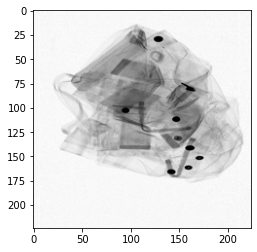

-0.028131042557257846
xrayTest/E004030006316908_2_990/1_15790014512_5E004030006316908.png
0.5816379


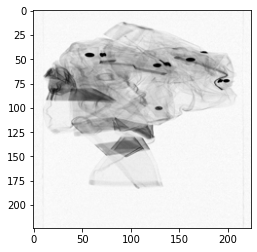

-0.04038600481991672
xrayTest/E004030006333988_3_598/0_15784006341_4E004030006333988_01001.png
0.57478666


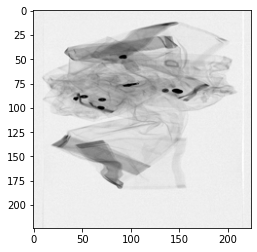

-0.44124027520714715
xrayTest/4_1_180/1_15743435450_4_0.png
0.68690836


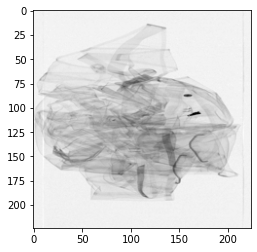

0.010522430025168061
xrayTest/E004010010630740_3_754/1_15790063904_4E004010010630740.png
0.6043593


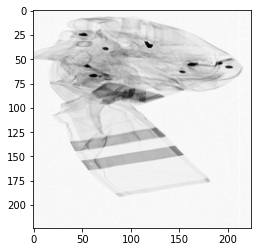

-0.01607415796018219
xrayTest/E004030006323A31_2_890/1_15784134710_4E004030006323A31.png
0.5885397


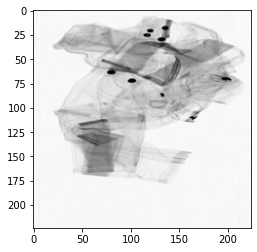

-0.06109225805242757
xrayTest/E004030006323A31_2_890/1_15784131405_5E004030006323A31.png
0.2139305


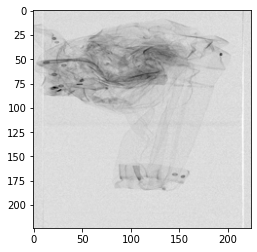

-0.06984408245128693
xrayTest/E004030006323A31_2_890/1_15784130257_5E004030006323A31.png
0.37388626


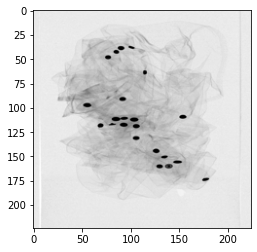

-0.08677236044832037
xrayTest/E004030006323A31_2_890/1_15790091230_5E004030006323A31.png
0.47111982


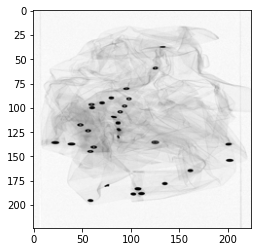

-0.09958523130129437
xrayTest/E004030006316908_2_990/0_15790047153_5E004030006316908_00010.png
0.9003395


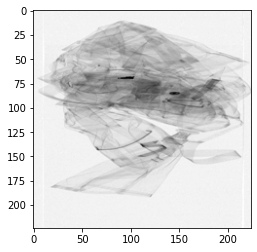

-0.03962999846475568
xrayTest/E004030006333988_3_598/1_15790048467_4E004030006333988.png
0.8560738


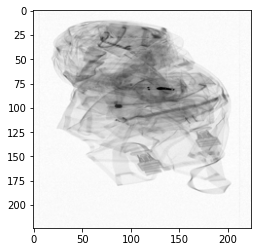

-0.09655390055356827
xrayTest/E004030006323A31_2_890/1_15790005394_5E004030006323A31.png
0.5453448


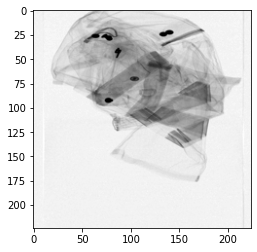

-0.027167165297045548
xrayTest/E004030006333988_3_598/0_15790064440_4E004030006333988_01011.png
0.5821837


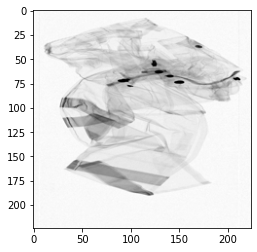

-0.009316763655331739
xrayTest/E004010010630740_3_754/0_15784046008_4E004010010630740_00001.png
0.59248


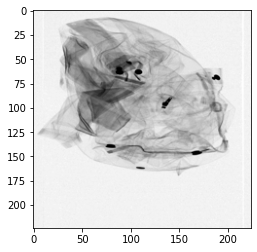

-0.015347401537451733
xrayTest/E004030006333988_3_598/0_15790005964_4E004030006333988_00001.png
0.8765473


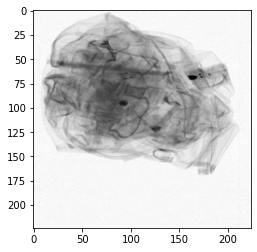

-0.2102867353451483
xrayTest/E004030006323A31_2_890/1_15790001771_5E004030006323A31.png
0.817988


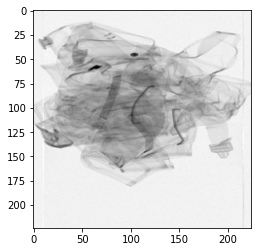

0.019345354204126308
xrayTest/E004030006316E18_1_303/1_15731337483_4_E004030006316E18_E004030006316E18.png
1.0095297


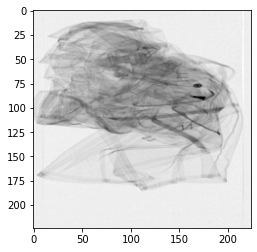

-0.095684845419155
xrayTest/E004030006323A31_2_890/1_15790006840_5E004030006323A31.png
0.9035445


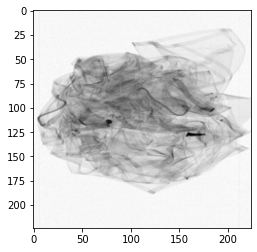

0.019738149220633883
xrayTest/E004030004D43BAE_2_512/1_15731376902_5_E004030004D43BAE_E004030004D43BAE.png
0.6100411


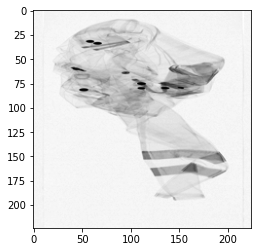

-0.00912393140154455
xrayTest/E004010010630740_3_754/1_15784115975_4E004010010630740.png
0.8819531


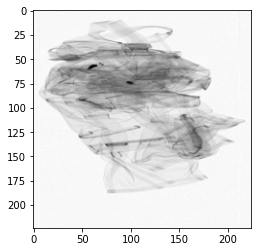

-0.08921588790454726
xrayTest/E004010010630740_3_754/1_15790080522_4E004010010630740.png
0.5490188


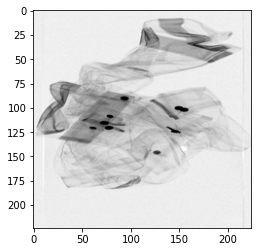

-0.037769135718638935
xrayTest/E004030006333988_3_598/0_15784132321_4E004030006333988_00011.png
0.85760885


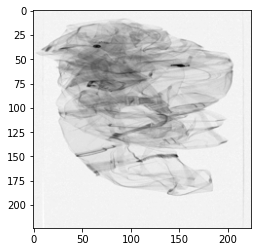

-0.026508087631361477
xrayTest/E004010010630740_3_754/0_15790045977_4E004010010630740_01001.png
0.29517546


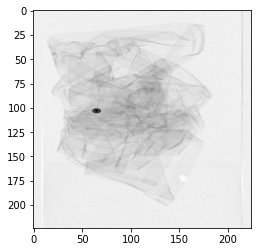

0.015542649702836031
xrayTest/E004010010630740_3_754/1_15790010134_4E004010010630740.png
0.60744125


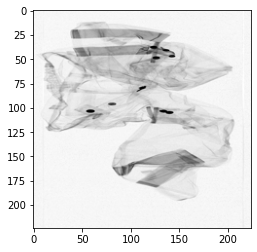

-0.011896343909246987
xrayTest/E004030006323A31_2_890/1_15790011846_5E004030006323A31.png
0.5909696


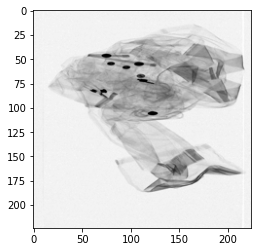

-0.11736198187996871
xrayTest/E004030006323A31_2_890/1_15784048195_5E004030006323A31.png
0.20315708


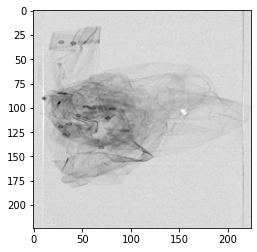

0.01305007837200356
xrayTest/E004030004D43BAE_2_512/1_15731349739_5_E004030004D43BAE_E004030004D43BAE.png
0.40528905


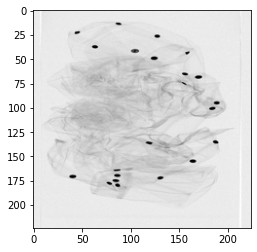

-0.09789205734387485
xrayTest/4_1_180/1_15743434028_4_0.png
1.1604055


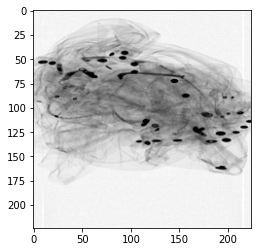

-0.06720021867735348
xrayTest/E004010010630740_3_754/0_15790033503_4E004010010630740_01001.png
0.16866563


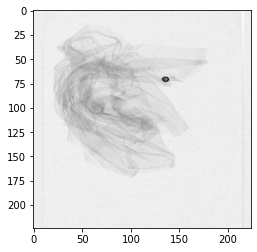

-0.05450447749009135
xrayTest/E004010010630740_3_754/1_15784065518_4E004010010630740.png
0.8439983


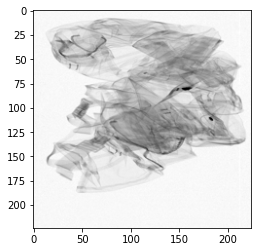

-0.06371351122541524
xrayTest/E004030006316908_2_990/1_15790049263_5E004030006316908.png
0.1692185


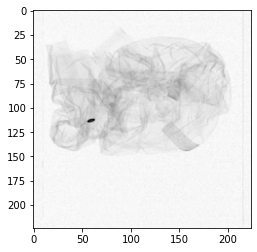

-0.09926091240590784
xrayTest/4_1_180/1_15743433273_4_.png
0.5440019


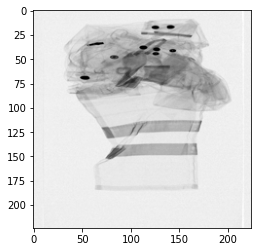

-0.1668083973475767
xrayTest/E004030006316908_2_990/1_15784016362_5E004030006316908.png
0.51250917


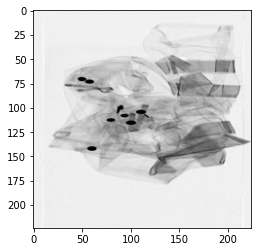

0.01600477452128901
xrayTest/E004030006316908_2_990/1_15790078513_5E004030006316908.png
1.0061024


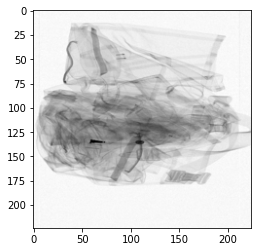

-0.12234495646831545
xrayTest/E004030006316908_2_990/1_15789991829_5E004030006316908.png
0.88208175


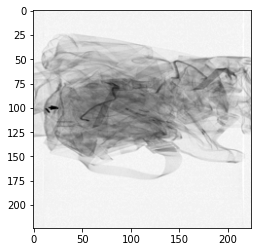

0.029295914833877057
xrayTest/E004030006316908_2_990/1_15784035601_5E004030006316908.png
0.6160477


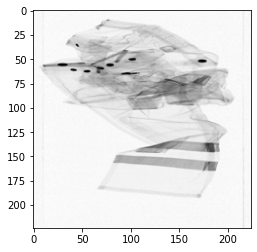

-0.03971834094064364
xrayTest/E004030006333988_3_598/0_15784070368_4E004030006333988_01001.png
0.49244106


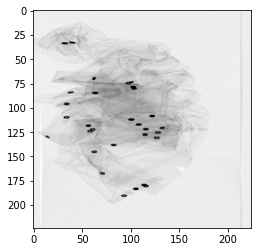

-0.0795886843877669
xrayTest/E004030006333988_3_598/0_15784166818_4E004030006333988_01101.png
0.9170159


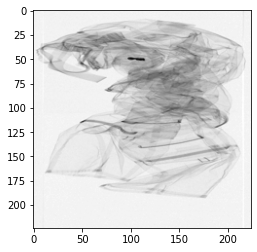

-0.018820575921125293
xrayTest/4_1_180/1_15743432773_4_.png
0.2974027


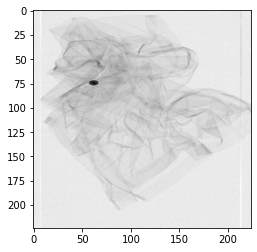

-0.016623951825344374
xrayTest/E004030006333988_3_598/0_15783992447_4E004030006333988_01001.png
0.8754466


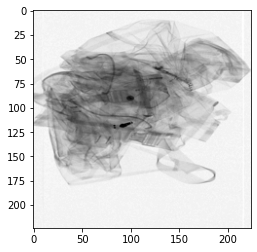

-0.046163853180912984
xrayTest/4_1_180/1_15743434680_4_0.png
0.5716122


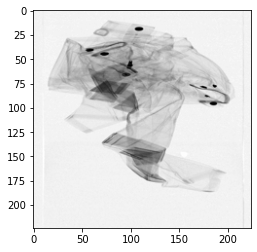

-0.03994172625087389
xrayTest/E004010010630740_3_754/1_15790038486_4E004010010630740.png
0.9519764


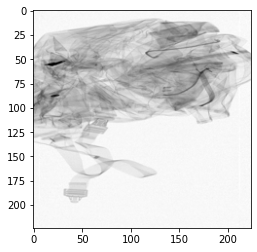

-0.014851363172865506
xrayTest/E004030004D43BAE_2_512/1_15731354864_5_E004030004D43BAE_E004030004D43BAE.png
0.8769757


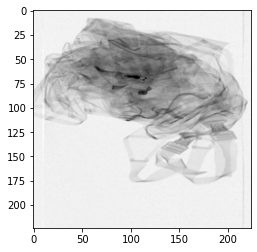

-0.04758925037813744
xrayTest/E004030006333988_3_598/0_15784010663_4E004030006333988_01001.png
0.8495696


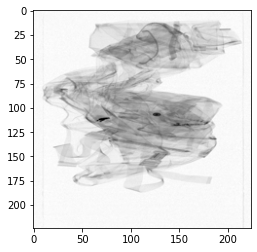

-0.15092027558970322
xrayTest/E004030006333988_3_598/0_15783998571_4E004030006333988_00001.png
1.1069403


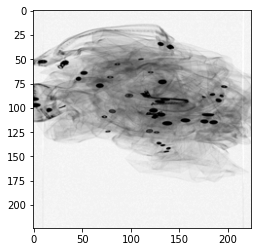

-0.08995581717881862
xrayTest/3_2_1274/_0_15737553334_4.png
0.5486461


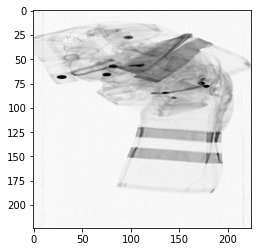

-0.03258656320278175
xrayTest/E004030006333988_3_598/0_15790037868_4E004030006333988_01100.png
0.29343787


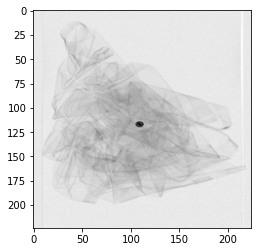

0.0054212677083691485
xrayTest/E004030006316328_2_400/1_15731372157_4_E004030006316328_E004030006316328.png
0.6012596


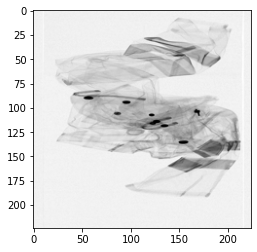

-0.029920636743993922
xrayTest/E004010010630740_3_754/1_15790097214_4E004010010630740.png
0.58062726


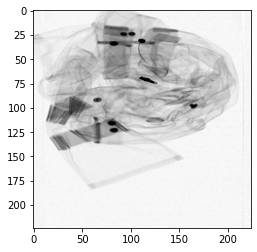

-0.0031623537617881947
xrayTest/E004030006316E18_1_303/1_15731340960_4_E004030006316E18_E004030006316E18.png
0.5961149


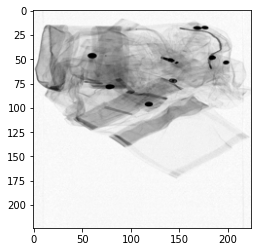

-0.005185371224785351
xrayTest/E004030006316328_2_400/1_15731353615_4_E004030006316328_E004030006316328.png
0.98489296


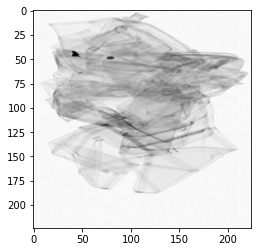

-0.3070114895493128
xrayTest/E004030006333988_3_598/0_15784037748_4E004030006333988_01111.png
0.97474277


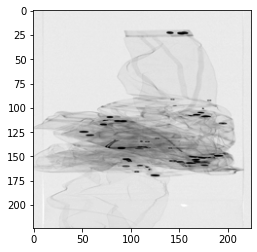

-0.03448588704022959
xrayTest/3_2_1274/_1_15737551596_4.png
0.5780649


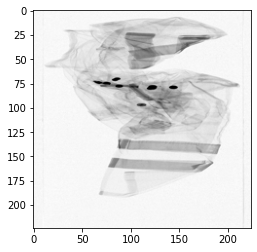

-0.09490760845511392
xrayTest/E004030006333988_3_598/0_15784002280_4E004030006333988_01000.png
1.1635685


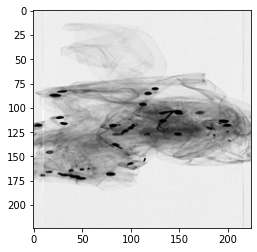

-0.03723034617894161
xrayTest/E004030006316908_2_990/1_15789997224_5E004030006316908.png
0.85805434


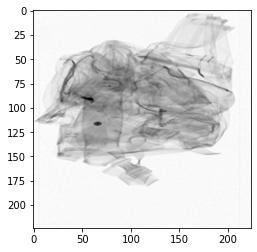

-0.004426653154125937
xrayTest/E004030006333988_3_598/0_15784009646_4E004030006333988_01001.png
0.17920671


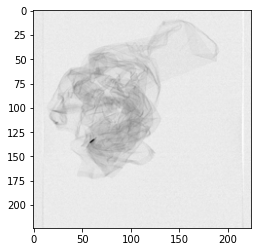

0.002303200020366103
xrayTest/E004030006333988_3_598/1_15790012838_4E004030006333988.png
0.5993805


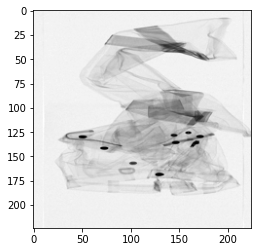

-0.1146943336666344
xrayTest/E004030006323A31_2_890/0_15790010269_5E004030006323A31_00010.png
0.88813585


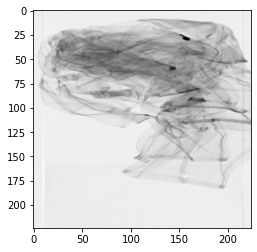

-0.03409983681390494
xrayTest/E004030006323A31_2_890/1_15784163128_5E004030006323A31.png
0.8606519


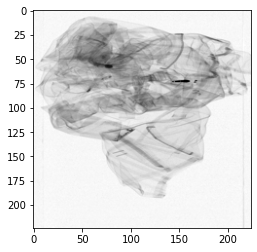

-0.05434133009136333
xrayTest/E004030006333988_3_598/0_15790040775_4E004030006333988_01010.png
0.93897486


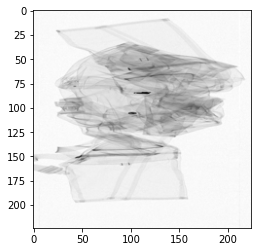

-0.0715579840125915
xrayTest/E004030006333988_3_598/0_15790097172_4E004030006333988_00001.png
0.83056635


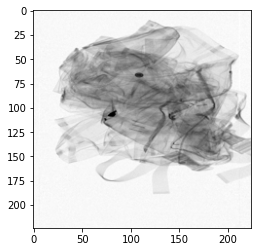

-0.0792501440552349
xrayTest/E004030006333988_3_598/0_15790096581_4E004030006333988_01100.png
0.3706277


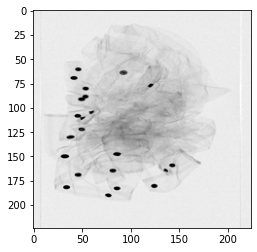

-0.030557348853637256
xrayTest/E004030006316908_2_990/1_15789990531_5E004030006316908.png
0.3881395


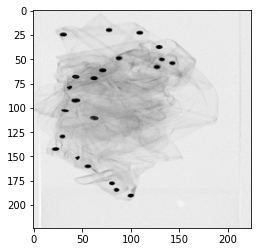

-0.06351895259109352
xrayTest/E004010010630740_3_754/0_15784065009_4E004010010630740_00001.png
0.5622843


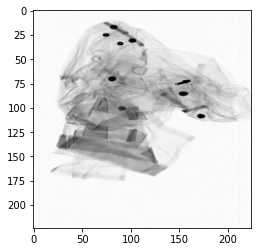

0.008720577151513642
xrayTest/E004030006333988_3_598/0_15783994718_4E004030006333988_00001.png
0.8978296


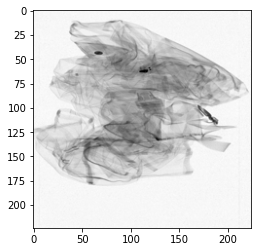

-0.03326567655083168
xrayTest/E004030006316E18_1_303/1_15731359824_4_E004030006316E18_E004030006316E18.png
0.5787476


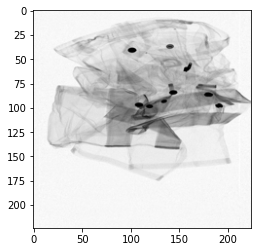

-0.016622913576185283
xrayTest/E004010010630740_3_754/0_15784059551_4E004010010630740_01000.png
0.8754475


KeyboardInterrupt: 

In [77]:
import time
n = []
nnon=[]
mse=0
hits=[0,0,0,0,0,0]
labeltrueVal = 0
labelval = 0
i=0
for b in range(0,test_generator.n):
  img,y= test_generator.next()
  img=img[0]
  label = y[0]
  predict = model.predict(np.expand_dims(img, axis=0))[0][0]
  val =(1-(label/predict))

  if val < 0.03:
      print(val)
      print(test_df['filename'][i])
      print(predict)
      img = img[:, :, 0]
      plt.imshow(img,cmap=plt.cm.binary_r)
      plt.show()
      #time.sleep(5)

  #BATCH
  labeltrueVal += label
  labelval +=predict
  i+=1

In [ ]:
import time
n = []
nnon=[]
mse=0
vals = []
ratios = []
labeltrueVal = 0
labelval = 0
i=0
for b in range(0,test_generator.n):
  img,y= test_generator.next()
  img=img[0]
  label = y[0]
  predict = model.predict(np.expand_dims(img, axis=0))[0][0]
  val =abs(1-(label/predict))
    
  img = img[:, :, 0]
  #plt.imshow(img,cmap=plt.cm.binary_r)
  #plt.show()
  im = Image.open("/home/lasg/bachelor-data/data/"+test_df['filename'][i])
  width, height = im.size

  ratio = height
  vals.append(val)
  ratios.append(ratio)
    
  if val > 0.20:
    print(test_df['filename'][i])
  

  i+=1




xrayTest/E004030006333988_3_598/0_15790044583_4E004030006333988_00011.png
xrayTest/E004030006333988_3_598/1_15790012838_4E004030006333988.png
xrayTest/E004030006333988_3_598/0_15790040775_4E004030006333988_01010.png
xrayTest/E004010010630740_3_754/0_15790002759_4E004010010630740_00001.png
xrayTest/E004030004D43BAE_2_512/1_15731336158_5_E004030004D43BAE_E004030004D43BAE.png
xrayTest/E004030006333988_3_598/0_15784000109_4E004030006333988_01001.png
xrayTest/7_1_227/1_15743454814_4_.png
xrayTest/E004030006316328_2_400/1_15731357927_4_E004030006316328_E004030006316328.png
xrayTest/E004030006323A31_2_890/1_15790077642_5E004030006323A31.png
xrayTest/E004030006323A31_2_890/1_15784041674_5E004030006323A31.png
xrayTest/E004030006333988_3_598/0_15783994941_4E004030006333988_01001.png
xrayTest/E004030006333988_3_598/0_15784048613_4E004030006333988_01100.png
xrayTest/E004030006333988_3_598/0_15789989288_4E004030006333988_01000.png
xrayTest/7_1_227/1_15743454955_4_0.png
xrayTest/E004030006316E18_1_3

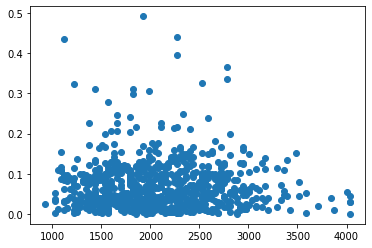

In [85]:
plt.scatter(ratios,vals)